Tests the audio models using the spectrogram data.

In [10]:
import os
import time

import torch
import torchaudio
import numpy as np
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

import cheapfake.contrib.video_processor as video_processor

ModuleNotFoundError: No module named 'torchaudio'

In [2]:
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)
audioprocessor = video_processor.AudioProcessor(verbose=True)

audio_signal = videofileprocessor._extract_all_audio(video_path, sample_rate=16000)

print(audio_signal.shape)

(160320,)


In [3]:
from IPython.display import Audio
Audio(audio_signal, rate=16000)

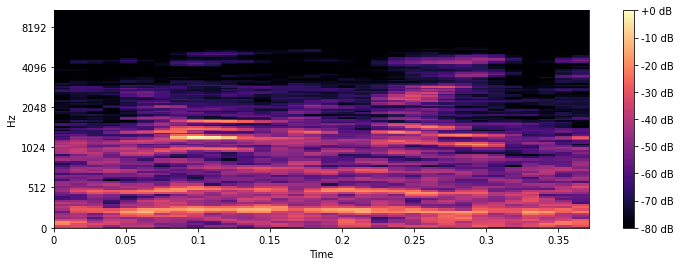

(128, 32)


In [7]:
spectrogram = audioprocessor.extract_spectrogram(
    audio_signal=audio_signal[:16000], sample_rate=16000, return_log=True, return_torch=False
)
audioprocessor.plot_spectrogram(spectrogram=spectrogram, sample_rate=16000, show_colorbar=True)

print(spectrogram.shape)

Looks like 16000 is actually a very good sampling rate. This change should be reflected in the default values that are taken (i.e. 44100 -> 16000)

In [9]:
class VGGVox(nn.Module):
    def __init__(self, nOut = 1024, encoder_type='SAP', **kwargs):
        super(VGGVox, self).__init__();
        
        self.encoder_type = encoder_type

        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))

        self.netcnn = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=(5,7), stride=(1,2), padding=(2,2)),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1,3), stride=(1,2)),

            nn.Conv2d(96, 256, kernel_size=(5,5), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),

            nn.Conv2d(256, 384, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),

            nn.Conv2d(256, 512, kernel_size=(4,1), padding=(0,0)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
        );

        if self.encoder_type == "MAX":
            self.encoder = nn.AdaptiveMaxPool2d((1,1))
            out_dim = 512
        elif self.encoder_type == "TAP":
            self.encoder = nn.AdaptiveAvgPool2d((1,1))
            out_dim = 512
        elif self.encoder_type == "SAP":
            self.sap_linear = nn.Linear(512, 512)
            self.attention = self.new_parameter(512, 1)
            out_dim = 512
        else:
            raise ValueError('Undefined encoder')

        self.fc = nn.Linear(out_dim, nOut)

        self.instancenorm   = nn.InstanceNorm1d(40)
        self.torchfb        = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=512, win_length=400, hop_length=160, f_min=0.0, f_max=8000, pad=0, n_mels=40)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out
        
    def forward(self, x):

        x = self.torchfb(x)+1e-6
        x = self.instancenorm(x.log()).unsqueeze(1).detach()

        x = self.netcnn(x);

        if self.encoder_type == "MAX" or self.encoder_type == "TAP":
            x = self.encoder(x)
            x = x.view((x.size()[0], -1))

        elif self.encoder_type == "SAP":
            x = x.permute(0, 2, 1, 3)
            x = x.squeeze(dim=1).permute(0, 2, 1)  # batch * L * D
            h = torch.tanh(self.sap_linear(x))
            w = torch.matmul(h, self.attention).squeeze(dim=2)
            w = F.softmax(w, dim=1).view(x.size(0), x.size(1), 1)
            x = torch.sum(x * w, dim=1)

        x = self.fc(x);

        return x;

NameError: name 'nn' is not defined